## DM vs. Drift

This notebook characterizes the relationship between the DM and the drift in order to obtain more relevant error bars

,trialDM,drift,drift_error,amplitude,xo,yo,sigmax,sigmay,theta,amp_error,xo_error,yo_error,sigmax_error,sigmay_error,angle_error
name,,,,,,,,,,,,,,,
2.0,554.103000,-1211.949089,1.756629,81.456411,512.495276,512.517846,175.342518,45.175511,-1.445552,0.037505,0.022957,0.080123,0.080907,0.020788,0.000180
2.0,555.346778,-1061.021269,1.345717,81.477084,512.494398,512.475208,175.785684,45.086342,-1.427963,0.037509,0.023543,0.080137,0.081101,0.020745,0.000179
2.0,556.590556,-945.975044,1.065801,81.461564,512.494540,512.469637,176.255553,44.979328,-4.552464,0.037390,0.024098,0.079911,0.081071,0.020631,0.000177
2.0,557.834333,-850.977556,0.861703,81.485651,512.494457,512.507588,176.823766,44.831076,42.588924,0.037416,0.024807,0.079983,0.081372,0.020575,0.000176
2.0,559.078111,-773.809053,0.710659,81.490387,512.494076,512.486396,177.364061,44.695356,-296.685813,0.037335,0.025501,0.079807,0.081441,0.020468,0.000174
2.0,560.321889,-710.033229,0.598827,81.484498,512.494651,512.485550,177.979551,44.552218,102.313444,0.037391,0.026328,0.079938,0.081843,0.020430,0.000173
2.0,561.565667,-656.107906,0.509870,81.489865,512.494554,512.463663,178.642315,44.393093,8.082485,0.037311,0.027103,0.079779,0.081971,0.020314,0.000171
2.0,562.809444,-608.943474,0.440263,81.524755,512.494905,512.475858,179.357440,44.202342,4.957912,0.037460,0.028085,0.080075,0.082595,0.020299,0.000170
2.0,564.053222,-569.548449,0.384448,81.514183,512.494650,512.490237,180.097685,44.035408,4.974152,0.037405,0.028944,0.079980,0.082825,0.020196,0.000169


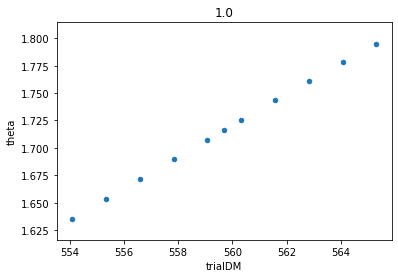

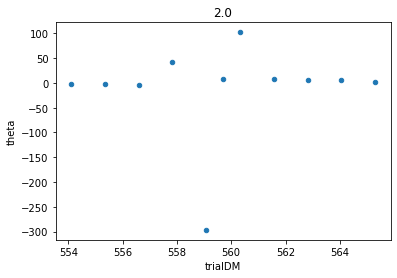

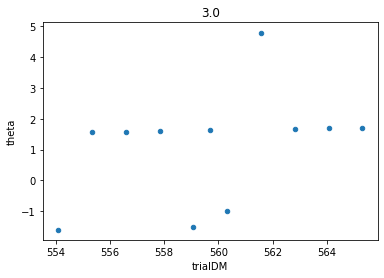

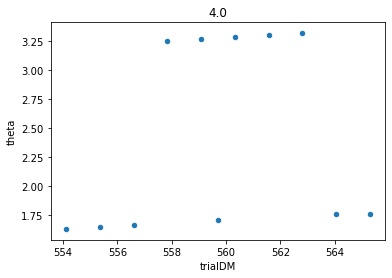

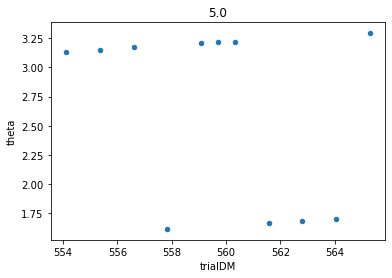

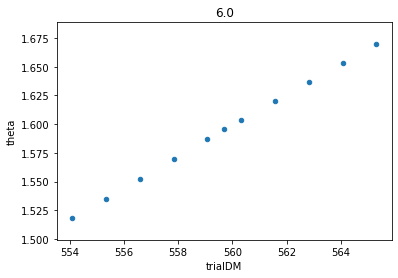

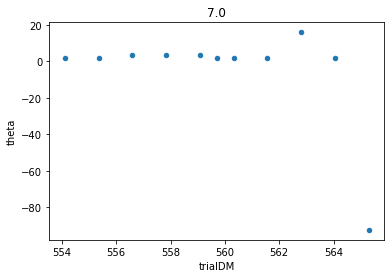

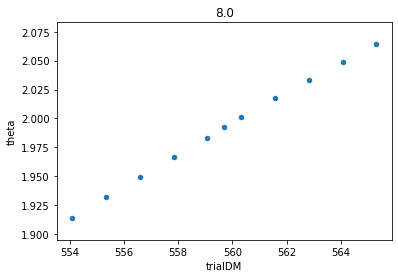

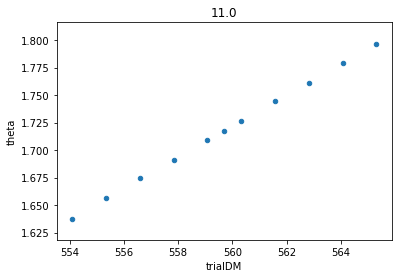

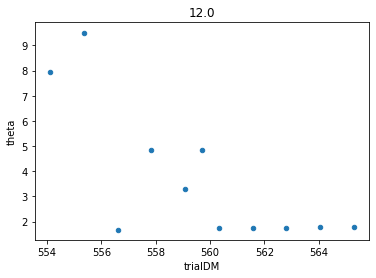

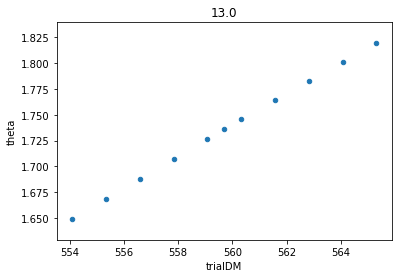

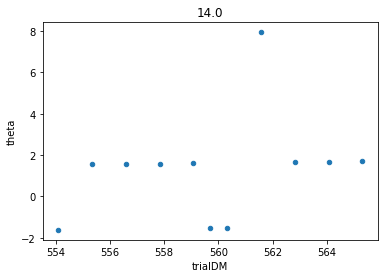

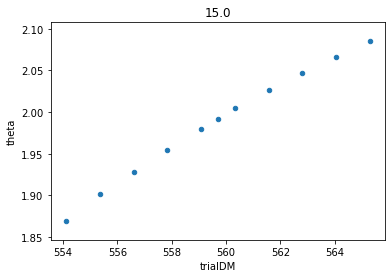

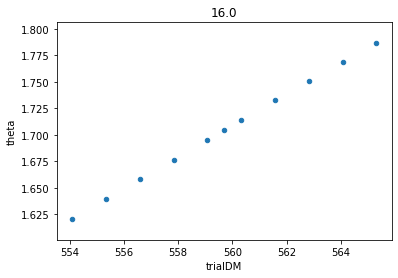

In [6]:
import pandas as pd
import numpy as np

covariancedata = pd.read_csv("frb121102_dmcovariance.csv")
covariancedata = covariancedata.set_index("name")
frb121102_centerDM = 559.7 # pc/cm^3


anglerange = []
for burst in covariancedata.index.unique():
    
    normalized_theta = [t if t < np.pi else t-np.pi for t in covariancedata.loc[burst]['theta'] % 2*np.pi] # theta is between 0 and pi
    anglerange.append([burst, np.min(normalized_theta), np.max(normalized_theta)])
    covariancedata.loc[burst].plot.scatter(x='trialDM', y='theta', title=str(burst))

covariancedata.loc[2]
# [t if t < np.pi else t-np.pi for t in covariancedata.loc[2]['theta'] % 2*np.pi]
    